<a href="https://colab.research.google.com/github/AstroNoodles/Mini-Projects/blob/master/Parallel_Sync_CNN_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parallel Synchronous Gradient Descent CNN Research
In this notebook, I am led by graduate student Pengzhan Guo to create a synchronous CNN that can be parallelized between multiple supercomputers and is optimized by the best gradient descent networks (ADAM or RMSProp).

The CNN will be trained using the CiFAR dataset which will predict images out of 10 classes and multiple trials of the experiment will be done.

In [75]:
!pip3 install tensorflow --upgrade

# Obtain the imports for the project
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, GlobalAveragePooling2D 
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Nadam

NUM_CLASSES = 10
EPOCHS = 400
BATCH_SIZE = 128


Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.14.0)


# Preprocessing the dataset
This is the step where visualization and preprocessing is done in the CIFAR10 dataset that Keras gives us.

In [76]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(f"The shape of the training data is {x_train.shape} and the shape of the labels are {y_train.shape}")

The shape of the training data is (50000, 32, 32, 3) and the shape of the labels are (50000, 1)


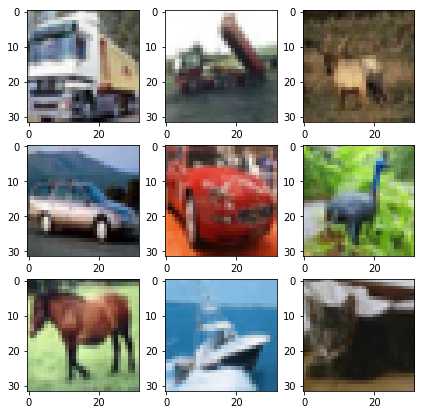

In [77]:
def visualize_cifar(train_data):
  """ Visualizes the cifar-10 dataset using matplotlib. This helps give a greater understanding
      of the items that are in the dataset"""
  plt.figure(figsize=(7, 7))
  for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(train_data[i])

visualize_cifar(x_train)


In [0]:
def normalize_data(x_train, x_test):
  mean_train, mean_test = np.mean(x_train), np.mean(x_test)
  std_train, std_test = np.std(x_train), np.std(x_test)
  return ((x_train - mean_train) / std_train, (x_test - mean_test) / std_test)
  

In [0]:
def smooth_label(labels, epsillion):
  """ Adds a smooth labeling to all the one-hot encoded labels to prevent overfitting
      in the dataset: https://tinyurl.com/kerastricks"""
  if 0 <= epsillion <= 1:
    labels *= (1.0 - epsillion)
    labels += (epsillion / labels.shape[1])
  else:
    raise Exception("Label smoothing factor should be between 0 and 1. Your factor is: " + str(epsillion))
  
  return labels
  

In [85]:
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

y_train = keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

smooth_label(y_train, 0.1)
print(y_train[0])

# Preprocessing the image dataset by artificially increasing the training data size
# via rescaling, shifting, flipping and rotating the dataset.
data_gen = ImageDataGenerator(
    featurewise_center=True,
    samplewise_center=True,
    rotation_range=90, 
    width_shift_range=.2, 
    height_shift_range=.2, 
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.0, 1.0),
    rescale=2)

data_gen.fit(x_train)

[[0.90999997 0.01       0.01       0.01       0.01       0.01
  0.01       0.01       0.01       0.01      ]
 [0.90999997 0.01       0.01       0.01       0.01       0.01
  0.01       0.01       0.01       0.01      ]
 [0.90999997 0.01       0.01       0.01       0.01       0.01
  0.01       0.01       0.01       0.01      ]
 [0.90999997 0.01       0.01       0.01       0.01       0.01
  0.01       0.01       0.01       0.01      ]
 [0.90999997 0.01       0.01       0.01       0.01       0.01
  0.01       0.01       0.01       0.01      ]
 [0.90999997 0.01       0.01       0.01       0.01       0.01
  0.01       0.01       0.01       0.01      ]
 [0.90999997 0.01       0.01       0.01       0.01       0.01
  0.01       0.01       0.01       0.01      ]
 [0.90999997 0.01       0.01       0.01       0.01       0.01
  0.01       0.01       0.01       0.01      ]
 [0.90999997 0.01       0.01       0.01       0.01       0.01
  0.01       0.01       0.01       0.01      ]
 [0.90999997 0.01  

# Building The Model
The model was built by using a combination of methods from the Inceptionv3 model and the VGGNet models that are on Github. The layers used are given in the imports in the first code cell.

In [0]:
def create_conv_net():
  model = Sequential()
  
  # Layer 1
  model.add(Conv2D(32, (3, 1), kernel_initializer="he_normal", input_shape=(32, 32, 3), 
                   padding="same", kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (1, 3), padding="same", kernel_regularizer=l2()))  
  model.add(Activation('relu'))
  model.add(MaxPooling2D(3, 2))
  model.add(BatchNormalization())
            
  # Layer 2
  model.add(Conv2D(64, (3, 1), padding="same", kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (1, 3), padding="same", kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(3, 2))
  model.add(BatchNormalization())
  model.add(Dropout(.4))          
            
  # Layer 3
  model.add(Conv2D(128, (3, 1), padding="same", kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(Conv2D(128, (1, 3), padding="same", kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(3, 2))
  model.add(BatchNormalization())
            
  # Layer 4
  model.add(Conv2D(256, (3, 1), padding="same", kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(Conv2D(256, (1, 3), padding="same", kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(3, 2))
  model.add(BatchNormalization())
  model.add(Dropout(.5))
   
  """
  # Layer 5
  model.add(Conv2D(512, (3, 1), padding="same", kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(Conv2D(512, (1, 3), padding="same", kernel_regularizer=l2()))
  model.add(Activation('relu'))
 # model.add(MaxPooling2D(3, 2))
  model.add(BatchNormalization())
  model.add(Dropout(.5)) 
  """
            
  # Layer 6 
  model.add(Flatten())
  model.add(Dense(256, kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  # Layer 7
  model.add(Dense(256, kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
            
  # Layer 8 
  model.add(Dense(256, kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(.5))
            
  # Layer 9
  # model.add(GlobalAveragePooling2D())
  model.add(Dense(NUM_CLASSES))
  model.add(Activation('softmax'))
  
  return model
           

In [87]:
model = create_conv_net()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 32, 32, 32)        320       
_________________________________________________________________
activation_133 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 32, 32, 32)        3104      
_________________________________________________________________
activation_134 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_73 (Batc (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 15, 15, 64)        6208      
__________

# Executing the Model
Now, the model built above will be executed with the training set in a parallel scope.

In [88]:
parallel = tf.distribute.experimental.MultiWorkerMirroredStrategy()

with parallel.scope():
  model.compile(optimizer=Nadam(), loss="categorical_crossentropy", metrics=['accuracy'])
  
model.fit_generator(data_gen.flow(x_train, y_train, batchsize=BATCH_SIZE), 
                    steps_per_epoch=(x_train.shape[0] // BATCH_SIZE), epochs=EPOCHS,
                    use_multiprocessing=True, workers=10, validation_data=(x_test, y_test))

W0729 20:13:42.142964 139973916657536 cross_device_ops.py:1182] Not all devices in `tf.distribute.Strategy` are visible to TensorFlow.


ValueError: ignored